# Preliminary operations and Import packages

In [1]:
# Keras e TF

import tensorflow as tf 
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
import cv2

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix
# Base
import os 
from matplotlib import pyplot as plt
import seaborn as sns # 
import numpy as np #
import pandas as pd # 
import matplotlib.cm as cm
import pydot
import pydotplus
from pydotplus import graphviz

# Functions

In [2]:
def get_img_array(img_path, size):

    # `Load img
    img = keras.preprocessing.image.load_img(img_path, target_size=size)

    # `Trasform the img to numpy array of shape (w, h, 3)
    array = keras.preprocessing.image.img_to_array(img)

    # Add a dimension to transform the array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array

In [3]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # img_array = img_array / 255.0
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [4]:
def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path, target_size = (400,400))
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    display(superimposed_img)

# Load Model

In [5]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/models/Oversampling_Augmentation')

In [6]:
# Load model
net_dcnn_112_over = keras.models.load_model("dcnn_model_112_v1_val_acc_best.hdf5")

# Inference - Class: COVID-19

## Load Image

In [7]:
# The local path to our target image
img_path = "C:/Users/marco/Desktop/Local_Documents/data/demo/MIDRC-RICORD-1C-419639-003257-00787-0.png"
im = cv2.imread(img_path)
# Label of the target image
label = pd.read_csv("C:/Users/marco/Desktop/Local_Documents/data/demo/demo.txt", sep=" ")

In [8]:
label.iloc[[0]]

,Img_path,Label
0,MIDRC-RICORD-1C-419639-003257-00787-0.png,COVID-19


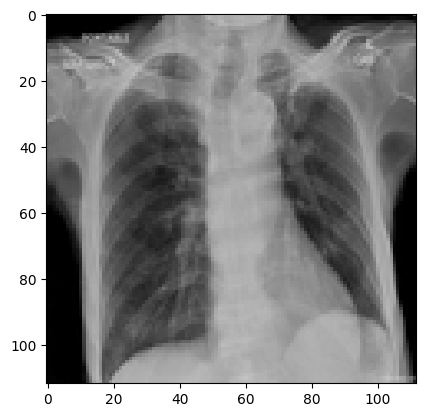

In [9]:
plt.imshow(im)

## Inference

In [10]:
# Target size
img_size = (112, 112)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = img_array / 255.0 # Rescale pixel to (0,1) according to network input

# Make a prediction and print the result

preds = net_dcnn_112_over.predict(img_array, verbose=1) 

if np.argmax(preds, axis=1)==0:
    print('Predicted: COVID-19')
elif np.argmax(preds, axis=1)==1:
    print('Predicted: Normal')
else:
    print('Predicted: Pneumonia')

1/1 [==============================] - 2s 2s/step
Predicted: COVID-19


In [11]:
label.iloc[[0]]

,Img_path,Label
0,MIDRC-RICORD-1C-419639-003257-00787-0.png,COVID-19


## Class activation heatmap

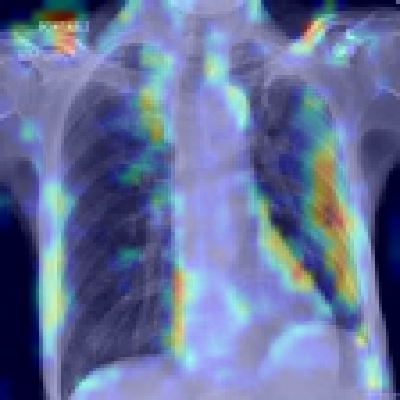

In [12]:
#Name of the last Conv Layer
last_conv_layer_name = "conv2d_11"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, net_dcnn_112_over, last_conv_layer_name)
display_gradcam(img_path, heatmap)

# Inference - Class: Pneumonia

## Load Image

In [13]:
# The local path to our target image
img_path = "C:/Users/marco/Desktop/Local_Documents/data/demo/1565fd6c-9432-454a-87e4-937fd5ad5b60.png"
im = cv2.imread(img_path)
# Label of the target image
label = pd.read_csv("C:/Users/marco/Desktop/Local_Documents/data/demo/demo.txt", sep=" ")

In [14]:
label.iloc[[2]]

,Img_path,Label
2,f12d7b12-0398-4533-8f55-8772cc434945.png,pneumonia


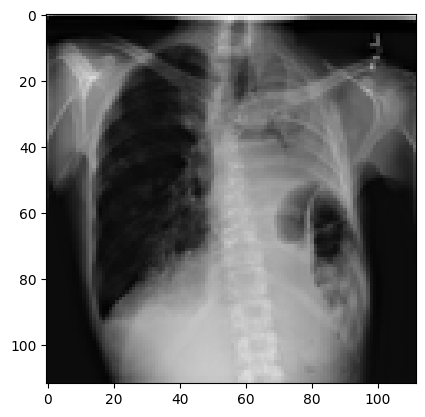

In [15]:
plt.imshow(im)

## Inference

In [16]:
# Target size
img_size = (112, 112)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = img_array / 255.0 # Rescale pixel to (0,1) according to network input

# Make a prediction and print the result

preds = net_dcnn_112_over.predict(img_array, verbose=1) 

if np.argmax(preds, axis=1)==0:
    print('Predicted: COVID-19')
elif np.argmax(preds, axis=1)==1:
    print('Predicted: Normal')
else:
    print('Predicted: Pneumonia')

1/1 [==============================] - 0s 26ms/step
Predicted: Pneumonia


In [17]:
label.iloc[[2]]

,Img_path,Label
2,f12d7b12-0398-4533-8f55-8772cc434945.png,pneumonia


### Display the map

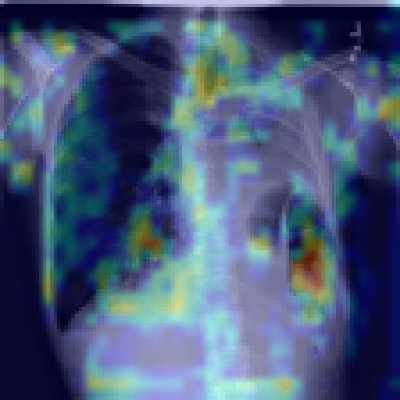

In [18]:
#Name of the last Conv Layer
last_conv_layer_name = "conv2d_11"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, net_dcnn_112_over, last_conv_layer_name)
display_gradcam(img_path, heatmap)

# Inference - Class: Normal

## Load Image

In [19]:
# The local path to our target image
img_path = "C:/Users/marco/Desktop/Local_Documents/data/demo/af6ef3d9-81c8-434e-bc5a-dbf89bc418aa.png"
im = cv2.imread(img_path)
# Label of the target image
label = pd.read_csv("C:/Users/marco/Desktop/Local_Documents/data/demo/demo.txt", sep=" ")

In [20]:
label.iloc[[1]]

,Img_path,Label
1,85bb48fe-e6d6-47de-bb71-d1636aced7dc.png,normal


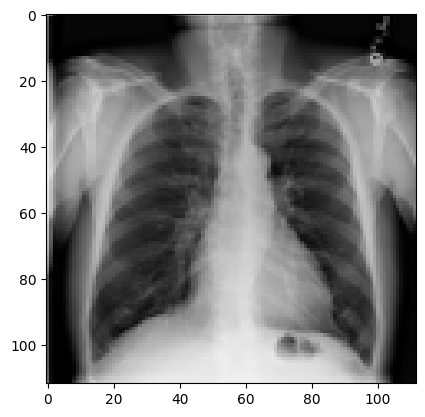

In [21]:
plt.imshow(im)

## Inference

In [22]:
# Target size
img_size = (112, 112)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = img_array / 255.0 # Rescale pixel to (0,1) according to network input

# Make a prediction and print the result

preds = net_dcnn_112_over.predict(img_array, verbose=1) 

if np.argmax(preds, axis=1)==0:
    print('Predicted: COVID-19')
elif np.argmax(preds, axis=1)==1:
    print('Predicted: Normal')
else:
    print('Predicted: Pneumonia')

1/1 [==============================] - 0s 21ms/step
Predicted: Normal


In [23]:
label[1:2]

,Img_path,Label
1,85bb48fe-e6d6-47de-bb71-d1636aced7dc.png,normal


## Class activation heatmap

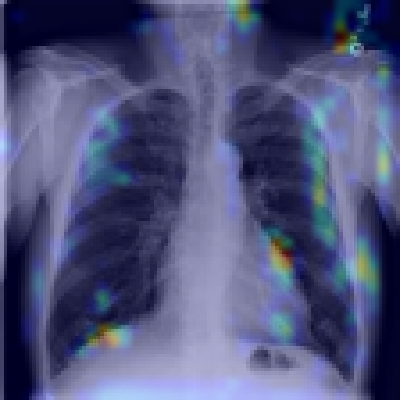

In [24]:
#Name of the last Conv Layer
last_conv_layer_name = "conv2d_11"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, net_dcnn_112_over, last_conv_layer_name)
display_gradcam(img_path, heatmap)